<h1 style = "color: #0000ff">Reti neurali convoluzionali per il riconoscimento di immagini</h1>

Lo scopo di questo progetto è quello di creare una rete neurale convoluzionale (CNN) che sia in grado di classificare immagini di volti umani in base all'espressione facciale (felice, triste, arrabbiata, sorpresa, spaventata o neutrale). Per allenare la rete, usiamo il dataset "FER-2013", disponibile a <a href = "https://www.kaggle.com/datasets/msambare/fer2013/data">questo link</a>, eliminando le immagini dell'espressione disgustata perché questa classe è sotto-rappresentata rispetto alle altre (ci sono circa un decimo delle immagini rispetto alle altre classi).\
Il dataset consiste di immagini 48×48 pixel in scala di grigi, separate in un set di allenamento (28273 immagini) e uno di test (7067 immagini). Alcuni esempi sono riportati in seguito.

Le reti neurali convoluzionali sono un tipo di rete neurale particolarmente adatto alla classificazione di immagini, perché sono in grado di analizzare la struttura intrinseca dei dati: nel caso delle immagini, non conta solo il colore dei pixel, ma anche la loro posizione relativa ai pixel circonstanti in entrambe le dimensioni; in una rete feed-forward questa informazione viene persa perché l'input deve essere monodimensionale. I dati possono avere anche una "terza dimensione", composta da canali. Questi possono essere ad esempio, in ingresso, i tre canali RGB.\
Una CNN è composta da strati "convoluzionali", dove i neuroni di uno strato non sono connessi a tutti quelli del successivo, ma solo a quelli in una regione piccola, tramite una convoluzione con un filtro, che viene fatto "scorrere" su tutto lo strato per generare un canale nello strato successivo. Questo permette anche di ridurre in modo siginificativo il numero di paramentri necessari rispetto a una FFNN.\
Ad esempio, in questo caso l'input ha dimensioni 48×48×1; applicando la convoluzione con 6 filtri 3×3, si ottiene un secondo strato 46×46×6, e così via.\
Si può modificare il modo in cui il filtro "scorre" sull'immagine, modificando il passo ("stride"), cioè il numero di pixel di cui si muove il filtro, o aggiungendo un "padding", cioè aumentando la dimesione spaziale dello strato con dei "pixel" dal valore nullo, in modo da mantenere uguale la dimensione dell'output. Nel caso dell'esempio precedente, aggiungendo un padding di 2 in entrambe le dimensioni, l'output ha nuovamente dimensioni 48×48×6.

Dopo uno strato convoluzionale, si può ridurre la dimensionalità spaziale dell'output con uno strato di "pooling": il "max pooling" consiste nel selezionare solo il "pixel" con il valore più alto in una certa regione. Nell'esempio precedente, possiamo dimezzare le dimensioni applicando un max pooling su regioni di dimensione 2×2 pixel, con un passo di 2 pixel, ottenendo una dimensione dell'output di 24×24×6.

Di seguito è riportato il codice necessario a inizializzare il progetto e caricare i dati da una cartella locale.

In [1]:
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

keras.backend.set_image_data_format("channels_last")

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# image parameters
HEIGHT, WIDTH, CHANNELS = 48, 48, 1
N_LABELS = 6
PATH = "expressions"

In [3]:
# load images as numpy arrays
trainData = keras.utils.image_dataset_from_directory(PATH + "/train", image_size = (HEIGHT, WIDTH),
                                                     batch_size = None, color_mode = "grayscale")
testData = keras.utils.image_dataset_from_directory(PATH + "/test", image_size = (HEIGHT, WIDTH),
                                                    batch_size = None, color_mode = "grayscale")
nTrain, nTest = len(trainData), len(testData)
classNames = trainData.class_names

trainImages, trainLabels = np.empty(shape = (nTrain, HEIGHT, WIDTH, CHANNELS)), np.empty(nTrain, dtype = int)
testImages, testLabels = np.empty(shape = (nTest, HEIGHT, WIDTH, CHANNELS)), np.empty(nTest, dtype = int)

i = 0
for image, label in trainData:
    trainImages[i] = image.numpy() / 255
    trainLabels[i] = label.numpy()
    i += 1
    
i = 0
for image, label in testData:
    testImages[i] = image.numpy() / 255
    testLabels[i] = label.numpy()
    i += 1
    
trainLabels = keras.utils.to_categorical(trainLabels)
testLabels = keras.utils.to_categorical(testLabels)
    
print("Data loaded")

Found 28273 files belonging to 6 classes.
Found 7067 files belonging to 6 classes.
Data loaded


Alcune immagini del dataset sono mostrate di seguito, tutte provenienti dal set di allenamento per la classe "neutrale". Si può osservare come il dataset sia piuttosto disomogeneo: contiene volti sia di adulti che di bambini, a volte in parte coperti (da mani, capelli, occhiali da sole, ombre...), non sempre visti di fronte, ma anche di tre quarti, di profilo o sdraiati, e alcune immagini sono addirittura tagliate nascondendo la bocca. Altre presentano invece un watermark in sovrimpressione e sono presenti anche volti disegnati, dipinti o in grafica 3D. Alcune immagini sono invece classificate in modo incerto.\
Per tutti questi motivi non ci aspettiamo di riuscire a ottenere un'accuratezza molto elevata.

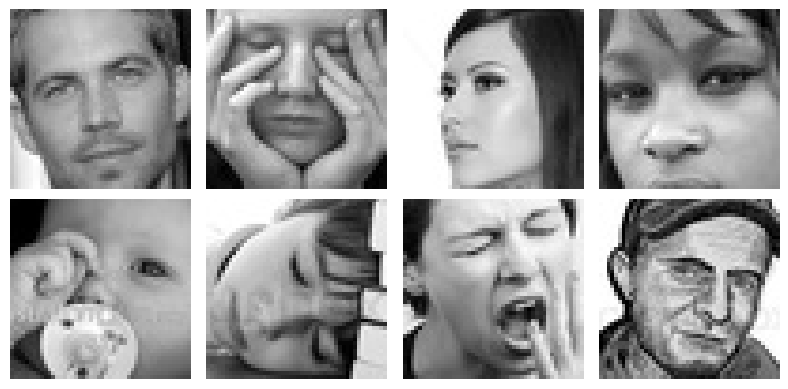

In [4]:
exampleImages = ["Training_2680328.jpg", "Training_14959913.jpg", "Training_600674.jpg", "Training_506670.jpg",
                 "Training_7360010.jpg", "Training_14971699.jpg", "Training_21335929.jpg", "Training_25592221.jpg"]

fig, ax = plt.subplots(2, 4, figsize = (8, 4))

for i, name in enumerate(exampleImages):
    x, y = i % 4, int(i / 4)
    im = Image.open(PATH + "/train/neutral/" + name)

    ax[y, x].imshow(im, cmap = "gray")
    ax[y, x].axis("off")

fig.tight_layout()
plt.show()

<h1 style = "color: #ff8800">Iperparametri</h1>

Per tutte le CNN create in seguito useremo le stesse funzioni di attivazione e di costo: per gli strati latenti la funzione di attivazione sarà una ReLU, definita come $f(x)=\max(0, x)$, mentre per lo strato di output sarà una funzione softmax, che trasforma i risultati $\mathbf{z}^{out}$ della rete in un vettore di probabilità nell'intervallo $[0,1]$. Questa funzione è definita per un vettore di input $\mathbf{x}$ come $\sigma_j (\mathbf{x}) = \frac{e^{x_j}}{\sum_{i}{e^{x_i}}}$. La classe predetta della rete sarà quindi $\hat{y}=\mathrm{argmax}(\mathbf{\sigma}(\mathbf{z}^{out}))$.

L'ottimizzatore scelto è l'algoritmo Adam: è un algoritmo iterativo e la sua implementazione avviene come descritto di seguito. Definiamo come $\mathbf{g}_t=\mathbf{\nabla}_\vec{\theta}C(\vec{\theta}_t)$ il gradiente della funzione costo rispetto ai parametri da ottimizzare a ogni passo $t$. Questo algoritmo calcola la media mobile di $g_i$ e $g_i^2$ (il primo e il secondo momento di $\mathbf{g}$, rispettivamente $\mathbf{m}$ ed $\mathbf{s}$) nel modo seguente:
$$
m_{t,i}=\beta_1 m_{t-1,i} + (1-\beta_1)g_{t,i}\\
s_{t,i}=\beta_2 s_{t-1,i} + (1-\beta_2)g_{t,i}^2\\
\hat{m}_{t,i}=\frac{m_{t,i}}{1-\beta_1^t}\\
\hat{s}_{t,i}=\frac{s_{t,i}}{1-\beta_2^t}.
$$
I parametri ottimizzati sono quindi, a ogni passo:
$$
\theta_{t+1,i} = \theta_{t,i} - \eta_t \frac{\hat{m}_{t,i}}{\sqrt{\hat{\sigma}_{t,i}}+\epsilon},
$$
dove $\eta$ è il tasso di apprendimento (che può variare nel tempo), $\beta_1$ e $\beta_2$ controllano quanti passi sono rilevanti nelle medie mobili ed $\epsilon$ impedisce ai valori di divergere. I parametri predefiniti nell'<a href = "https://keras.io/api/optimizers/adam/">implementazione di Keras</a> sono: $\eta = 0.001$, $\beta_1=0.9$, $\beta_2=0.999$, $\epsilon=10^{-7}$.

La funzione di costo scelta è l'entropia incrociata ("categorical crossentropy" in Keras), definita per il singolo campionamento come:
$$
\ell(\vec{y},\hat{\vec{y}})=-\sum_{k=1}^Ky_k\log(\hat{y}_k),
$$
dove $K$ è il numero di classi, e visto che le "probabilità" reali sono codificate in vettori "one-hot", $y_k\neq0$ solo per la classe corretta. La funzione costo totale è quindi $C(\vec{\theta}) = \sum_{i=1}^N\ell(\vec{y}_i,\hat{\vec{y}}_i)$.\
Inoltre abbiamo anche usato un regolarizzazione ridge per i parametri della convoluzione, che aggiunge alla funzione di costo un termine $\lambda\Vert\vec{\theta}\Vert^2$, dove $\lambda$ è un iperparametro, il cui <a href = "https://keras.io/api/layers/regularizers/#l2-class">valore predefinito in Keras</a> è di $\lambda = 0.01$.

Per prima cosa vogliamo quindi studiare quali siano gli iperparametri $\eta$ e $\lambda$ ottimali per una rete semplice, che poi utilizzeremo per costruire reti più complesse. Per trovarli effettuiamo una grid search sui 5 ordini di grandezza da $10^{-5}$ a $10^{-1}$, con una rete veloce da allenare, composta da due strati convoluzionali con 6 e 12 filtri, e uno completamente connesso da 100 neuroni che porta allo strato di output (andrà allenata per tutte le 25 combinazioni di $\eta$ e $\lambda$). L'allenamento avviene su 8 epoche, perché per un numero maggiore la rete va in overfitting (l'accuratezza non sale ma la loss aumenta). L'accuratezza per tutte le combinazioni dei due iperparametri è riportata nei grafici sottostanti.

In [59]:
N_ETA, N_LAM = 5, 5
etaVec = np.logspace(-5, -1, N_ETA)
lamVec = np.logspace(-5, -1, N_LAM)

In [60]:
def createCNNhp(eta, lam):
    model = Sequential()
    model.add(Conv2D(6, 5, activation = "relu", input_shape = (HEIGHT, WIDTH, CHANNELS), kernel_regularizer = l2(lam)))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(12, 5, activation = "relu", kernel_regularizer = l2(lam)))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(100, activation = "relu", kernel_regularizer = l2(lam)))
    model.add(Dense(N_LABELS, activation = "softmax"))
    
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = Adam(learning_rate = eta), metrics = ["acc"])
    return model

In [61]:
# matrix of CNNs (hp = hyperparameter)
CNNhps = np.empty((N_ETA, N_LAM), dtype = object)

In [62]:
for i in range(len(etaVec)):
    for j in range(len(lamVec)):
        model = createCNNip(etaVec[i], lamVec[j])
        model.fit(trainImages, trainLabels, batch_size = 32,
                  epochs = 8, validation_data = (testImages, testLabels))
        CNNhps[i, j] = model

Epoch 1/8
884/884 [==============================] - 14s 15ms/step - loss: 1.7717 - acc: 0.2362 - val_loss: 1.7635 - val_acc: 0.2510
Epoch 2/8
884/884 [==============================] - 28s 32ms/step - loss: 1.7561 - acc: 0.2552 - val_loss: 1.7562 - val_acc: 0.2512
Epoch 3/8
884/884 [==============================] - 26s 30ms/step - loss: 1.7479 - acc: 0.2554 - val_loss: 1.7466 - val_acc: 0.2516
Epoch 4/8
884/884 [==============================] - 32s 36ms/step - loss: 1.7355 - acc: 0.2577 - val_loss: 1.7307 - val_acc: 0.2612
Epoch 5/8
884/884 [==============================] - 27s 30ms/step - loss: 1.7160 - acc: 0.2720 - val_loss: 1.7093 - val_acc: 0.2732
Epoch 6/8
884/884 [==============================] - 30s 33ms/step - loss: 1.6939 - acc: 0.2925 - val_loss: 1.6870 - val_acc: 0.3059
Epoch 7/8
884/884 [==============================] - 30s 33ms/step - loss: 1.6716 - acc: 0.3172 - val_loss: 1.6662 - val_acc: 0.3281
Epoch 8/8
884/884 [==============================] - 29s 32ms/step - 

884/884 [==============================] - 25s 28ms/step - loss: 1.7591 - acc: 0.2552 - val_loss: 1.7610 - val_acc: 0.2510
Epoch 4/8
884/884 [==============================] - 24s 27ms/step - loss: 1.7588 - acc: 0.2552 - val_loss: 1.7611 - val_acc: 0.2510
Epoch 5/8
884/884 [==============================] - 21s 24ms/step - loss: 1.7589 - acc: 0.2552 - val_loss: 1.7614 - val_acc: 0.2510
Epoch 6/8
884/884 [==============================] - 21s 24ms/step - loss: 1.7589 - acc: 0.2552 - val_loss: 1.7606 - val_acc: 0.2510
Epoch 7/8
884/884 [==============================] - 25s 28ms/step - loss: 1.7587 - acc: 0.2552 - val_loss: 1.7612 - val_acc: 0.2510
Epoch 8/8
884/884 [==============================] - 20s 22ms/step - loss: 1.7586 - acc: 0.2552 - val_loss: 1.7615 - val_acc: 0.2510
Epoch 1/8
884/884 [==============================] - 21s 23ms/step - loss: 1.6772 - acc: 0.3134 - val_loss: 1.5789 - val_acc: 0.3690
Epoch 2/8
884/884 [==============================] - 22s 25ms/step - loss: 1.56

In [100]:
trainAcc = np.empty((N_ETA, N_LAM))
testAcc = np.empty((N_ETA, N_LAM))

for i in range(N_ETA):
    for j in range(N_LAM):
        CNN = CNNhps[i, j]

        trainAcc[i, j] = CNN.evaluate(trainImages, trainLabels)[1]
        testAcc[i, j] = CNN.evaluate(testImages, testLabels)[1]

221/221 [==============================] - 1s 6ms/step - loss: 1.8215 - acc: 0.2510


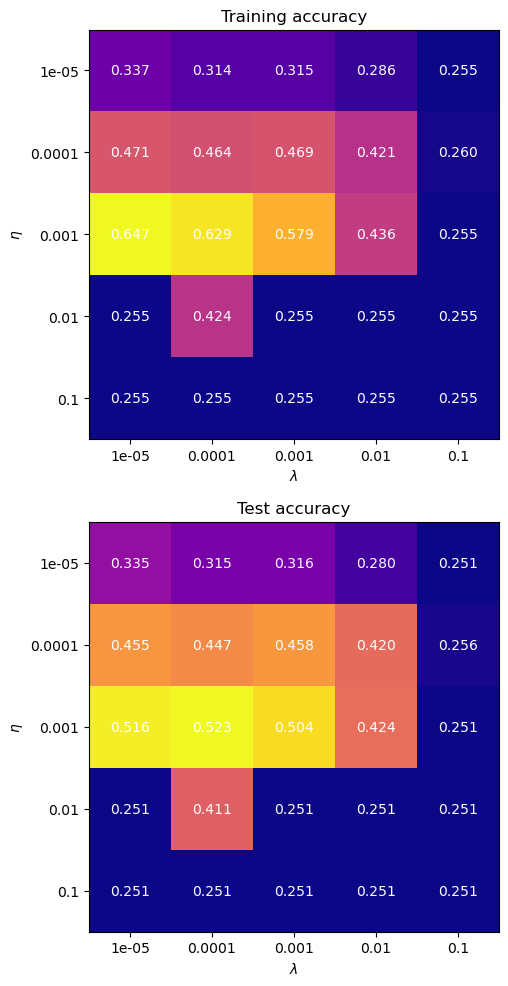

In [101]:
fig, ax = plt.subplots(2, 1, figsize = (5, 10))

def heatmap(ax, matrix, title, xlabel, ylabel, xvalues, yvalues):
    xdim = matrix.shape[1]
    ydim = matrix.shape[0]
    ax.imshow(matrix, cmap = "plasma", interpolation = "nearest")
    ax.set(title = title, xlabel = xlabel, ylabel = ylabel,
              xticks = np.arange(xdim), xticklabels = xvalues, yticks = np.arange(ydim), yticklabels = yvalues)

    for i in range(ydim):
        for j in range(xdim):
            text = ax.text(j, i, "%.3f" % (matrix[i, j]), ha = "center", va = "center", color = "#ffffff")
            
heatmap(ax[0], trainAcc, "Training accuracy", r"$\lambda$", r"$\eta$", lamVec, etaVec)
heatmap(ax[1], testAcc, "Test accuracy", r"$\lambda$", r"$\eta$", lamVec, etaVec)

fig.tight_layout()
plt.show()

Da questa ricerca, basandoci sull'accuratezza del test, troviamo che il tasso di apprendimento migliore è $\eta=0.001$, che è già il valore predefinito da Keras per l'algoritmo Adam, mentre per il parametro della regolarizzazione troviamo $\lambda=10^{-4}$. Con questa semplice rete superiamo di poco il $50\%$ di accuratezza, che è comunque un buon risultato per quanto visto in seguito.

In [5]:
eta = 0.001 # since 0.001 is the default option, we will ignore it
lam = 0.0001

Di seguito sono riportati come esempio alcune predizioni della rete con questi parametri.

In [6]:
def exampleImages(h, w, predictions):
    fig, ax = plt.subplots(h, w, figsize = (2 * w, 2 * h))
    ind = np.random.randint(0, len(testImages), w * h)

    for i, j in enumerate(ind):
        x, y = i % w, int(i / w)
        ax[y, x].imshow(testImages[j], cmap = "gray")
        lab = np.argmax(testLabels[j])
        guess = np.argmax(predictions[j])
        color = "#00aa00"
        if lab != guess:
            color = "#aa0000"
        ax[y, x].set_title("%s\npredicted: %s" % (classNames[lab], classNames[guess]), color = color)
        ax[y, x].axis("off")
        ax[y, x].grid(False)
    
    fig.tight_layout()
    plt.show()

221/221 [==============================] - 1s 6ms/step


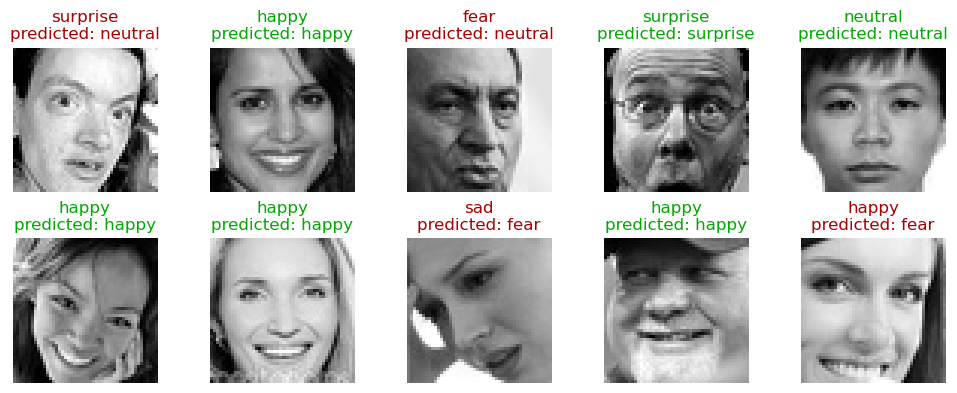

In [99]:
predictions = CNNhps[2, 1].predict(testImages)
exampleImages(2, 5, predictions)

<h1 style = "color: #ff8800">Architetture</h1>

Vogliamo ora creare delle reti più complesse per migliorare l'accuratezza delle predizioni. Per fare questo possiamo aumentare il numero di filtri e di strati.

Di seguito è riportato il codice generale per creare e allenare una rete, ma per l'analisi di questa sezione le reti sono state create in precedenza, salvate e poi caricate quando necessario.

In [126]:
# train parameters
EPOCHS = 20
BATCH_SIZE = 32

In [8]:
def evaluate(model, history):
    score = model.evaluate(testImages, testLabels, verbose = 1)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    
    plotHistory(history)
    
def plotHistory(h):
    fig, ax = plt.subplots(2, 1, figsize = (8, 8))
    
    ax[0].plot(h["acc"], label = "train")
    ax[0].plot(h["val_acc"], label = "test")
    ax[0].set(xlabel = "Epoch", ylabel = "Model accuracy")
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(h["loss"], label = "train")
    ax[1].plot(h["val_loss"], label = "test")
    ax[1].set(xlabel = "Epoch", ylabel = "Model loss")
    ax[1].legend()
    ax[1].grid(True)
    
    plt.show()
    
def save(path, model, history):
    model.save(filepath = path + ".h5", include_optimizer=True)
    np.save(path + ".npy", history.history)
    
def load(path):
    model = keras.models.load_model(filepath = path + ".h5")
    history = np.load(path + ".npy", allow_pickle = True).item()
    return model, history

In [133]:
# model creation
model = Sequential()
model.add(Conv2D(36, 5, padding = "valid", activation = "relu", input_shape = (HEIGHT, WIDTH, CHANNELS), kernel_regularizer = l2(lam)))
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))

model.add(Conv2D(72, 3, padding = "valid", activation = "relu", kernel_regularizer = l2(lam)))
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))

model.add(Conv2D(144, 3, padding = "valid", activation = "relu", kernel_regularizer = l2(lam)))
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))

model.add(Conv2D(144, 3, padding = "valid", activation = "relu", kernel_regularizer = l2(lam)))
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(72, activation = "relu", kernel_regularizer = l2(lam)))
model.add(Dropout(0.25))

model.add(Dense(N_LABELS, activation = "softmax"))

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["acc"])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_73 (Conv2D)          (None, 44, 44, 36)        936       
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 22, 22, 36)       0         
 g2D)                                                            
                                                                 
 dropout_70 (Dropout)        (None, 22, 22, 36)        0         
                                                                 
 conv2d_74 (Conv2D)          (None, 20, 20, 72)        23400     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 10, 10, 72)       0         
 g2D)                                                            
                                                                 
 dropout_71 (Dropout)        (None, 10, 10, 72)      

In [132]:
# model training
history = model.fit(trainImages, trainLabels, batch_size = BATCH_SIZE,
          epochs = EPOCHS, validation_data = (testImages, testLabels))

Epoch 1/20
884/884 [==============================] - 89s 100ms/step - loss: 1.7732 - acc: 0.2550 - val_loss: 1.7654 - val_acc: 0.2510
Epoch 2/20
884/884 [==============================] - 88s 99ms/step - loss: 1.7614 - acc: 0.2552 - val_loss: 1.7618 - val_acc: 0.2510
Epoch 3/20
884/884 [==============================] - 88s 100ms/step - loss: 1.7596 - acc: 0.2552 - val_loss: 1.7613 - val_acc: 0.2510
Epoch 4/20
884/884 [==============================] - 89s 100ms/step - loss: 1.7587 - acc: 0.2552 - val_loss: 1.7609 - val_acc: 0.2510
Epoch 5/20
884/884 [==============================] - 90s 102ms/step - loss: 1.7585 - acc: 0.2552 - val_loss: 1.7606 - val_acc: 0.2510
Epoch 6/20
884/884 [==============================] - 89s 101ms/step - loss: 1.7583 - acc: 0.2552 - val_loss: 1.7605 - val_acc: 0.2510
Epoch 7/20
884/884 [==============================] - 89s 101ms/step - loss: 1.7583 - acc: 0.2552 - val_loss: 1.7607 - val_acc: 0.2510
Epoch 8/20
884/884 [==============================] - 89

KeyboardInterrupt: 

In [107]:
save("model9_50D", model, history)

Di seguito sono riportate varie CNN, con la loro struttura e i grafici di accuratezza e loss. L'accuratezza massima non aumenta di molto rispetto a quella della semplice rete precedente, meno del $10\%$.

<h3>Prima rete</h3>

Per prima cosa possiamo provare ad aumentare di molto il numero di filtri e strati, allenando una rete con 4 strati convoluzionali da 64, 128, 256 e 512 filtri 3×3, e uno strato completamente connesso da 256 neuroni, oltre che agli strati di input e output. Dimezziamo le dimensioni degli output dopo ogni strato convoluzionale con un max pooling. Questo approccio risulta errato, come mostrato dai grafici sottostanti: l'accuratezza resta attorno al $52\%$, e dopo 15 epoche la rete inizia a overfittare.

In [78]:
m, h = load("model4_15")
m.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 6, 6, 256)       

221/221 [==============================] - 16s 72ms/step - loss: 1.3461 - acc: 0.5236
Test loss: 1.3460623025894165
Test accuracy: 0.5235602259635925


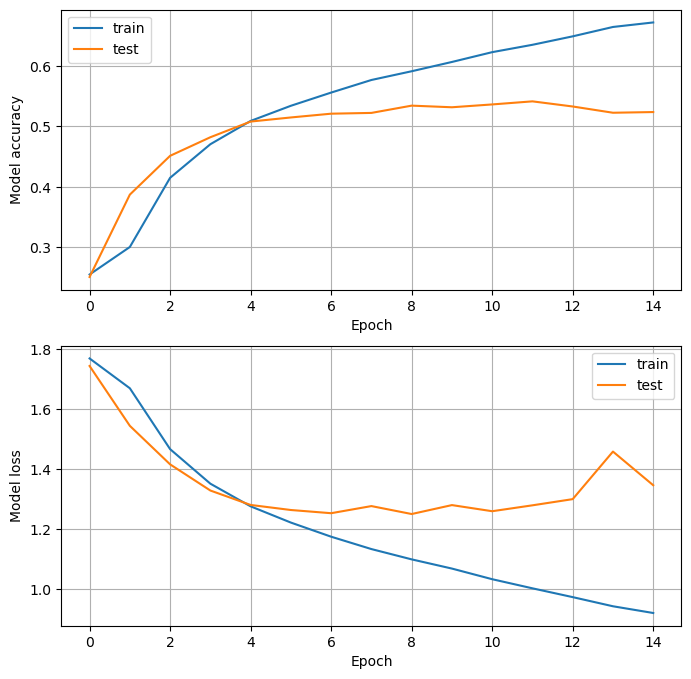

In [79]:
evaluate(m, h)

Possiamo inserire degli strati di "dropout", cioè strati che "spengono" casualmente dei neuroni durante ogni ciclo della fase di allenamento (non durante il test) con una certa probabilità, diminuendo il rischio di overfitting e aumentando la capacità di generalizzazione della rete. Proprio per questo la loss di allenamento è solitamente maggiore di quella di test.

Inseriamo due strati di dropout, con probabilità del $25\%$, dopo il secondo strato convoluzionale e prima dello strato completamente connesso. La rete migliora la sua accuratezza di circa l'$1\%$ in 15 epoche, ma comunque dobbiamo scegliere un'architettura differente.

In [80]:
m, h = load("model4_15D")
m.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 12, 12, 128)       0         
                                                                 
 conv2d_51 (Conv2D)          (None, 12, 12, 256)     

221/221 [==============================] - 16s 71ms/step - loss: 1.2344 - acc: 0.5349
Test loss: 1.2344145774841309
Test accuracy: 0.5348804593086243


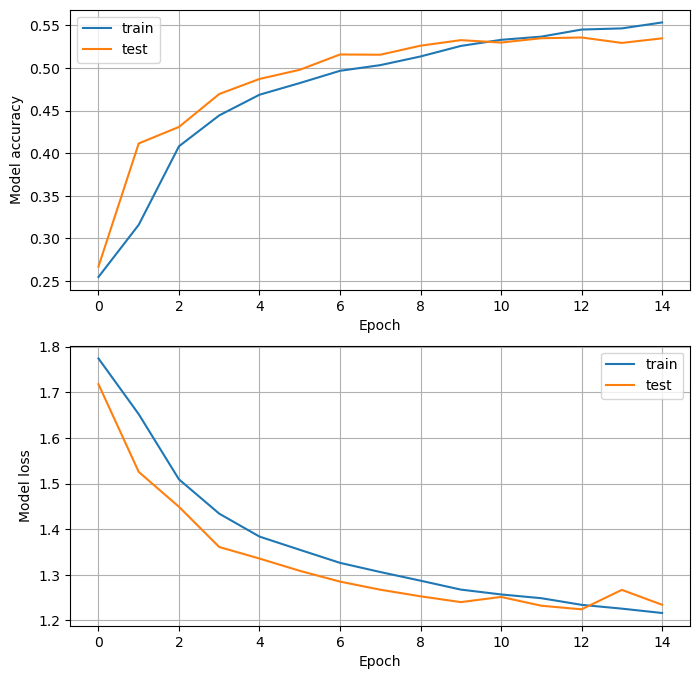

In [81]:
evaluate(m, h)

<h3>Seconda rete e overfitting</h3>

Creiamo ora una rete con architettura simile alla precedente, senza dropoout e con 5 strati convoluzionali da 32, 64, 128, 256 e 512 filtri. In questo modo l'output di questi strati è già monodimensionale. Il modello migliora raggiungendo un'accuratezza del $55\%$ circa. Sfruttiamo questo esempio per mostrare cosa succede in caso di overfitting: come è evidente dai grafici sottostanti, già dopo circa 6 epoche di allenamento l'accuratezza smette di migliorare, mentre la loss del test coninua a crescere dopo aver raggiunto un minimo.

In [84]:
m, h = load("model5_20")
m.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 6, 6, 128)      

221/221 [==============================] - 6s 26ms/step - loss: 1.8170 - acc: 0.5533
Test loss: 1.8170146942138672
Test accuracy: 0.5532757639884949


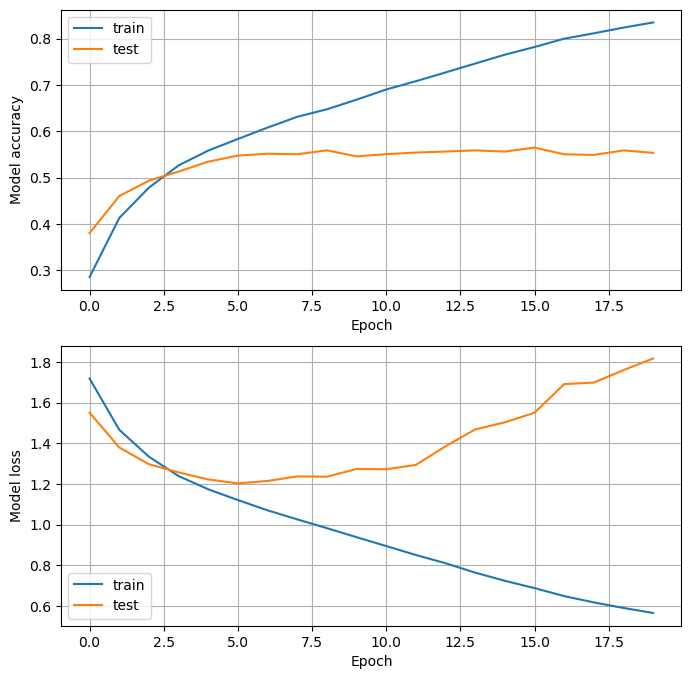

In [85]:
evaluate(m, h)

<h3>Terza rete</h3>

Questa rete è simile alle precedenti, ma con meno filtri e senza padding negli strati convoluzionali. È composta da 4 strati convoluzionali, con 36 filtri 5×5 nel primo strato e 72, 144 e 144 filtri 3×3 negli altri, e da uno strato completamente connesso da 72 neuroni. Dopo ognuno di questi strati è stato inserito uno strato di dropoput al $25\%$.\
Questa rete ha un numero di parametri molto inferiore alle precedenti, ma si comporta meglio, con un'accuratezza del $58\%$ circa.

In [114]:
m1, h1 = load("model9_50D")
m1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 44, 44, 36)        936       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 22, 22, 36)       0         
 g2D)                                                            
                                                                 
 dropout_55 (Dropout)        (None, 22, 22, 36)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 20, 20, 72)        23400     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 10, 10, 72)       0         
 g2D)                                                            
                                                                 
 dropout_56 (Dropout)        (None, 10, 10, 72)      

221/221 [==============================] - 4s 17ms/step - loss: 1.1696 - acc: 0.5758
Test loss: 1.169634461402893
Test accuracy: 0.5757747292518616


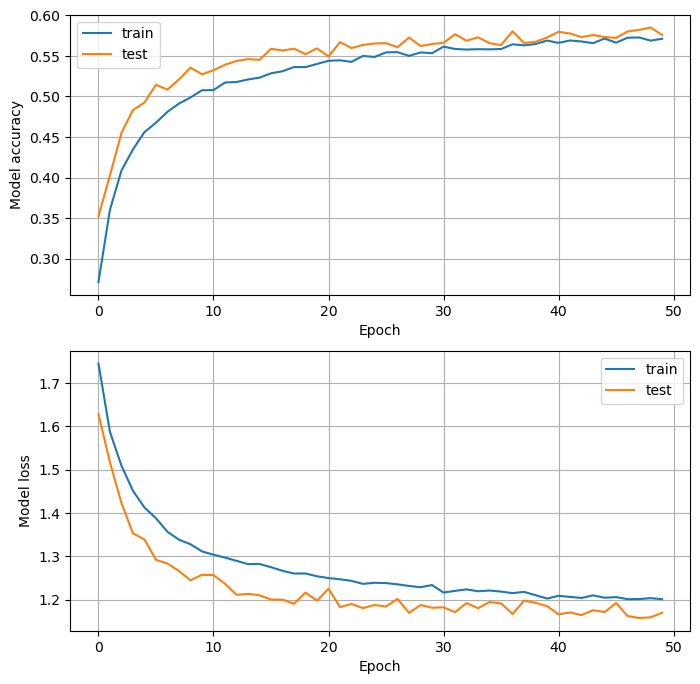

In [115]:
evaluate(m1, h1)

Di seguito sono riportate alcune predizioni di questa CNN.

In [116]:
predictions1 = m1.predict(testImages)

221/221 [==============================] - 3s 14ms/step


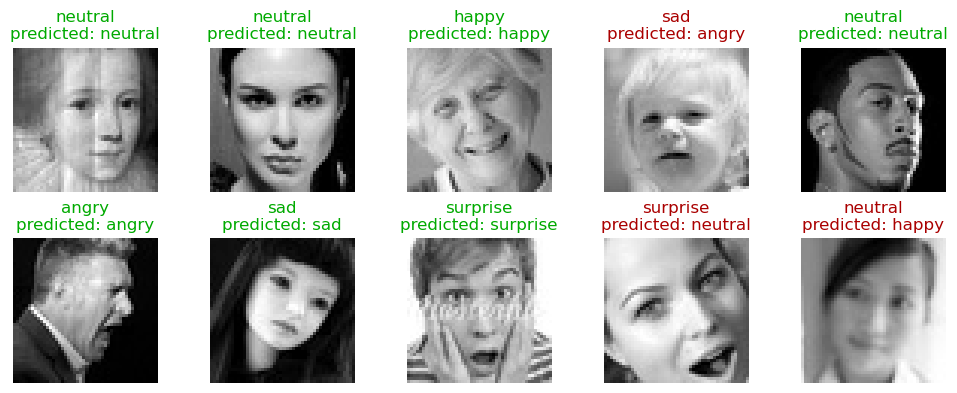

In [143]:
exampleImages(2, 5, predictions1)

<h3>Rete finale</h3>

La rete con accuratezza maggiore che abbiamo costruito è simile alla precedente, con uno strato in più, ma nel complesso ha meno paramentri. È composta da 5 strati convoluzionali: tra i primi due, da 32 e 64 filtri, non è presente uno strato di pooling, mentre lo è dopo il secondo e dopo tutti i successivi, da 64, 128 e 128 filtri. Dopo ogni strato di pooling e dopo quello completamente connesso da 64 neuroni, c'è uno strato di dropout al $25\%$.\
Questa rete raggiunge un'accuratezza del $61\%$. Alcune predizioni sono riportante nelle immagini sottostanti.

In [121]:
m2, h2 = load("decent")
m2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 conv2d_33 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                 

221/221 [==============================] - 8s 34ms/step - loss: 1.1100 - acc: 0.6113
Test loss: 1.1100105047225952
Test accuracy: 0.6112919449806213


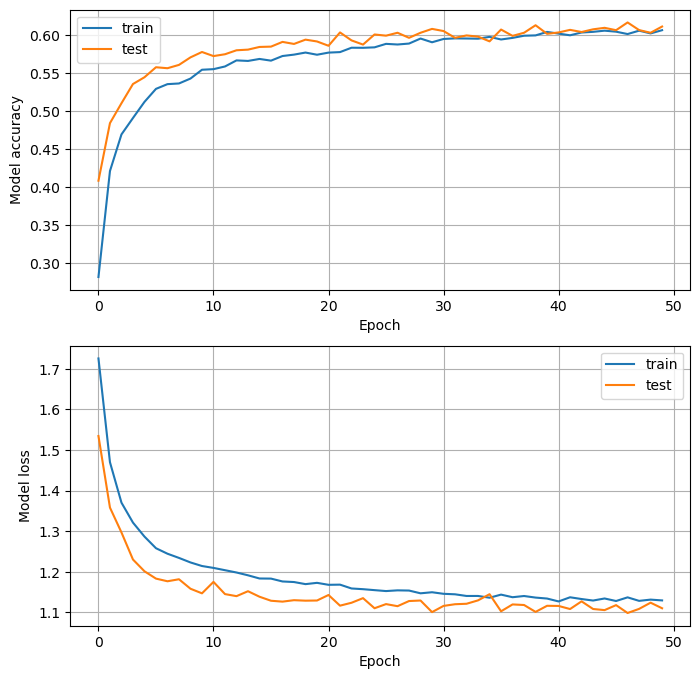

In [123]:
evaluate(m2, h2)

In [141]:
predictions2 = m2.predict(testImages)

221/221 [==============================] - 14s 61ms/step


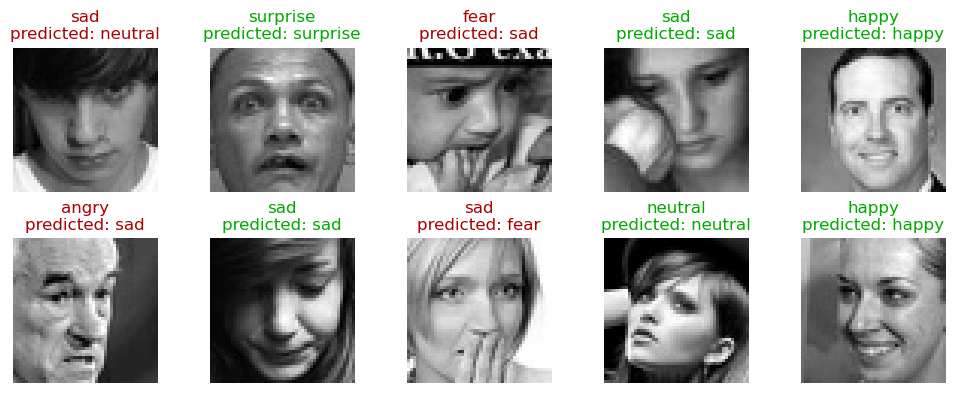

In [142]:
exampleImages(2, 5, predictions2)

<h1 style = "color: #ff8800">Conclusioni</h1>

Il risultato finale, cioè una CNN con accuratezza del $61\%$ nel riconoscere le espressioni facciali del dataset FER-2013, è soddisfacente, considerando le problematiche associate al dataset di partenza e alla semplicità delle architetture studiate. Questo valore è in linea con il $65\%$ circa di accuratezza delle <a href = "https://www.kaggle.com/datasets/msambare/fer2013/code?datasetId=786787&sortBy=voteCount">migliori soluzioni presenti sul sito da cui proviene il dataset</a>, che utilizzano modelli più complessi con tecniche più avanzate.

Dalle reti che abbiamo testato, possiamo concludere che un eccessivo numero di paramentri è controproducente, perché il modello inizia a fare overfitting molto presto e l'accuratezza non migliora rispetto a modelli più semplici e/o con molti meno parametri. Reti con più strati convoluzionali e un minor numero di parametri danno risultati migliori per questo dataset, e gli stradi di dropout giocano sicuramente un ruolo fondamentale nel migliorare le capacità predittive di queste reti neurali.

Possiamo verificare il comportamento delle due reti migliori anche con immagini prese da internet, non presenti nel dataset di allenamento. Le predizioni sono riportate sopra ogni immagine.

In [64]:
import glob

bonusImages = np.empty(shape = (12, HEIGHT, WIDTH))

for i, name in enumerate(glob.glob(PATH + "/bonus/*.png")):
    bonusImages[i] = Image.open(name).convert("L")
    
bonusImages = bonusImages.reshape((12, HEIGHT, WIDTH, CHANNELS))

1/1 [==============================] - 0s 63ms/step


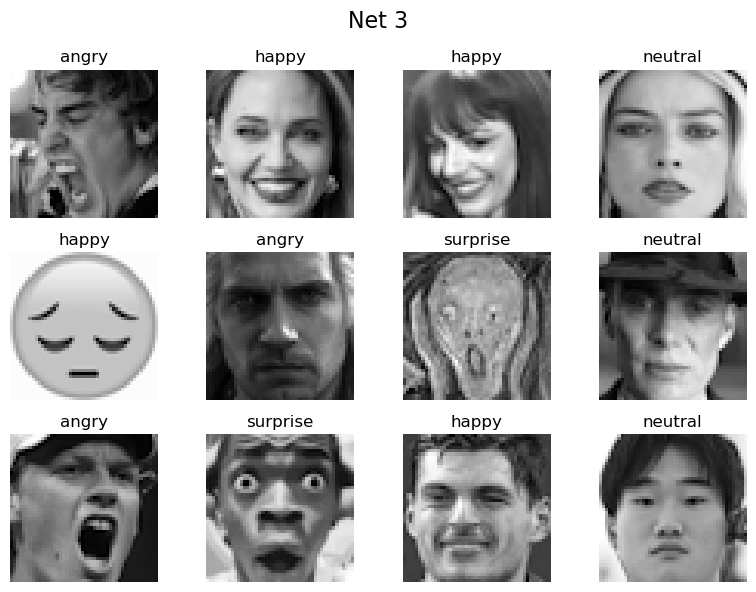

In [139]:
bonusLabels = m1.predict(bonusImages)

fig, ax = plt.subplots(3, 4, figsize = (8, 6))

for i, image in enumerate(bonusImages):
    x, y = i % 4, int(i / 4)
    ax[y, x].imshow(image, cmap = "gray")
    ax[y, x].set(title = classNames[np.argmax(bonusLabels[i])])
    ax[y, x].axis("off")

fig.suptitle("Net 3", fontsize = 16)
fig.tight_layout()
plt.show()

1/1 [==============================] - 0s 94ms/step


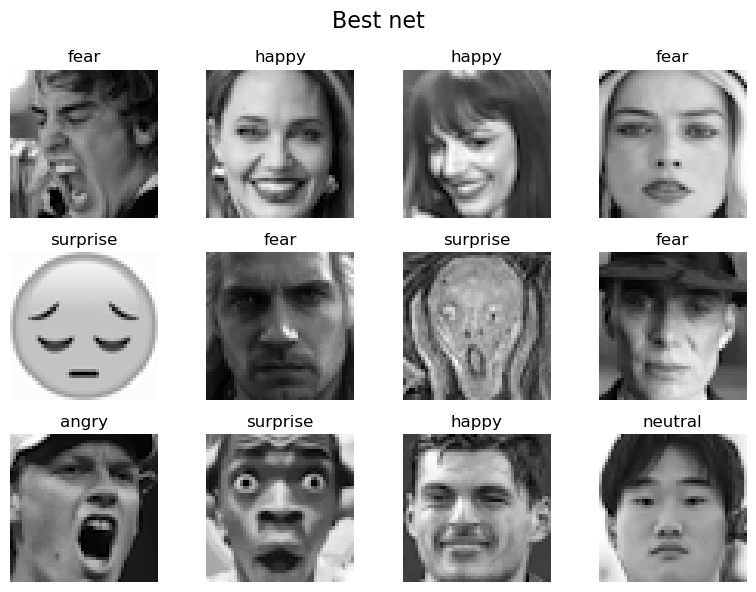

In [140]:
bonusLabels = m2.predict(bonusImages)

fig, ax = plt.subplots(3, 4, figsize = (8, 6))

for i, image in enumerate(bonusImages):
    x, y = i % 4, int(i / 4)
    ax[y, x].imshow(image, cmap = "gray")
    ax[y, x].set(title = classNames[np.argmax(bonusLabels[i])])
    ax[y, x].axis("off")

fig.suptitle("Best net", fontsize = 16)
fig.tight_layout()
plt.show()

Infine, possiamo analizzare quale sia l'accuratezza per ogni classe. Dal risultato sottostante, concludiamo che la classe peggiore per i nostri modelli è quella relativa all'espressione spaventata, che è infatti definita in modo ambiguo, confondendosi spesso con espressioni neutrali, tristi o stupite. Alcuni esempi sono riportati di seguito.\
Probabilmente, rimuovendo questa classe, l'accuratezza delle reti aumenterebbe in modo significativo.

In [153]:
def classAccuracies(predictions): 
    Ncorrect, Ntot = np.zeros(N_LABELS), np.zeros(N_LABELS)
    for i, y in enumerate(predictions):
        pred = np.argmax(y)
        correct = np.argmax(testLabels[i])
        Ntot[correct] += 1
        if pred == correct:
            Ncorrect[pred] += 1

    for i in range(N_LABELS):
        print("Accuracy for class \"" + classNames[i] + "\":\t" + str(Ncorrect[i] / Ntot[i]))
        
print("For net 3:")
classAccuracies(predictions1)

print("\nFor the best net:")
classAccuracies(predictions2)

For net 3:
Accuracy for class "angry":	0.5
Accuracy for class "fear":	0.1220703125
Accuracy for class "happy":	0.8664036076662909
Accuracy for class "neutral":	0.624493106244931
Accuracy for class "sad":	0.41379310344827586
Accuracy for class "surprise":	0.7725631768953068

For the best net:
Accuracy for class "angry":	0.5125260960334029
Accuracy for class "fear":	0.16796875
Accuracy for class "happy":	0.8669673055242391
Accuracy for class "neutral":	0.6545012165450121
Accuracy for class "sad":	0.5597433841218925
Accuracy for class "surprise":	0.7388688327316486


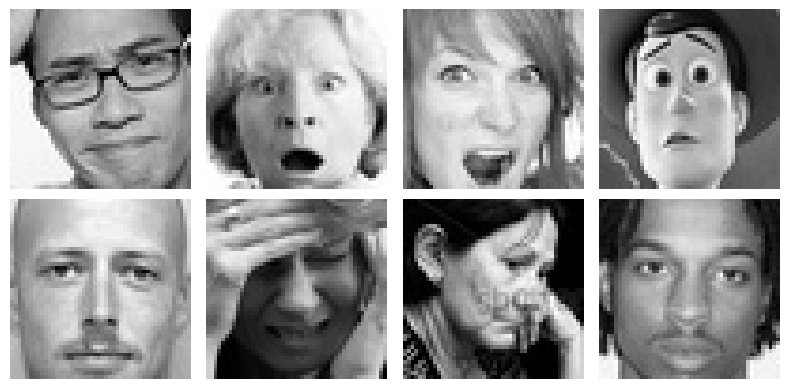

In [159]:
exampleImages = ["Training_1077665.jpg", "Training_1139919.jpg", "Training_1044537.jpg", "Training_1243725.jpg",
                 "Training_1440087.jpg", "Training_1483019.jpg", "Training_2120718.jpg", "Training_2526432.jpg"]

fig, ax = plt.subplots(2, 4, figsize = (8, 4))

for i, name in enumerate(exampleImages):
    x, y = i % 4, int(i / 4)
    im = Image.open(PATH + "/train/fear/" + name)

    ax[y, x].imshow(im, cmap = "gray")
    ax[y, x].axis("off")

fig.tight_layout()
plt.show()